In [32]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import deque
from tqdm import tqdm  
import pandas as pd
import copy

In [33]:
P_0_matrix=np.array([[0.005,0.793,0.202],
                   [0.027,0.558,0.415],
                   [0.736,0.249,0.015]])

P_0_matrix


array([[0.005, 0.793, 0.202],
       [0.027, 0.558, 0.415],
       [0.736, 0.249, 0.015]])

In [34]:
P_1_matrix=np.array([[0.718,0.254,0.028],
                   [0.347,0.097,0.556],
                   [0.015,0.956,0.029]])
P_1_matrix

array([[0.718, 0.254, 0.028],
       [0.347, 0.097, 0.556],
       [0.015, 0.956, 0.029]])

In [35]:
action_space=[0,1]
state_space=[0,1,2]
reward_matrix=[[0,0.699],[0,0.362],[0,0.715]]
N=200
M=80
epsilon=1.0
subsidy=0.00
arm_indexes=[i for i in range(N)]
gamma=0.999

In [36]:
def step(state,state_space,action,P_0_matrix,P_1_matrix,reward_matrix):
  new_state=state
  if(action==1):
    new_state=np.random.choice(state_space,replace=True,p=P_1_matrix[state])
    reward=reward_matrix[state][1]
  else:
    new_state=np.random.choice(state_space,replace=True,p=P_0_matrix[state])
    reward=reward_matrix[state][0]
  return [new_state,reward]

In [37]:
# Q=copy.deepcopy(reward_matrix)
Q=np.zeros((len(state_space),len(action_space)))

In [38]:


def act(Q_values,epsilon,state):
  if np.random.random()<epsilon:
    action=random.choice([0,1])
  else:
    action=np.argmax(Q_values[state])
  return action

In [39]:
alternative_indexes=[0 for _ in range(N)]
current_state=[random.choice([0,1,2]) for _ in range(N)]
nu=np.zeros((len(state_space),len(action_space)))
nu.shape

(3, 2)

In [40]:
rewards=[]
subsidies=[]
action_sums=[]
betas=[]
alphas=[]
epsilon=0.1

In [41]:
def alpha(i):
    return 1/(1+(i/10000))
    # return 0.02

In [42]:
epsilons=[]
threshold=0.1
subsidy=0.5


In [43]:
for i in range(1,300000):
  # top_M_indices=act(alternative_indexes,N,M,epsilon)
  action_sum=0
  reward_sum=0
  # alpha=1/np.ceil(1+i/1000)
  # if(i<50000):
  #   beta=0
  # else:
  if i%50==0:
    beta=1/(1+np.ceil((i)*np.log(i)/10000))
  else:
    beta=0
  # beta=0.005
  for index in arm_indexes:
      # action=np.argmax(Q_values[index][current_state[index]])
      if i%5000==0:
        action=act(Q,1,current_state[index])
      else:
        action=act(Q,epsilon,current_state[index])
      action_sum+=action
      x=step(current_state[index],state_space,action,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      if action==1:
        Q[current_state[index]][action]=(1-alpha(nu[current_state[index],action]))*(Q[current_state[index]][action])+alpha(nu[current_state[index],action])*(reward+max(Q[new_state])-(np.array(Q).sum())/6)
      else:
        Q[current_state[index]][action]=(1-alpha(nu[current_state[index],action]))*(Q[current_state[index]][action])+alpha(nu[current_state[index],action])*(reward+subsidy+max(Q[new_state])-(np.array(Q).sum())/6)
      nu[current_state[index],action]=nu[current_state[index],action]+1
      current_state[index]=new_state
      reward_sum+=reward
      #print(x)
  # print(i)
  #print(reward_sum)
  
  subsidy=subsidy+beta*(action_sum-M)/N
  subsidies.append(subsidy)
  # epsilon=epsilon*gamma

  # if epsilon<threshold:
  #   epsilon=threshold
  # if i%500000==0:
  #   threshold=threshold/10
  # epsilon=epsilon*0.999
  # if epsilon<=0.001:
  #   epsilon=0.001
  rewards.append(reward_sum)
  action_sums.append(action_sum)
  epsilons.append(epsilon)
  betas.append(beta)
  alphas.append(alpha)








In [44]:
i

299999

In [45]:
epsilon

0.1

Text(0.5, 1.0, 'Subsidy vs Steps for Non Indexable Example')

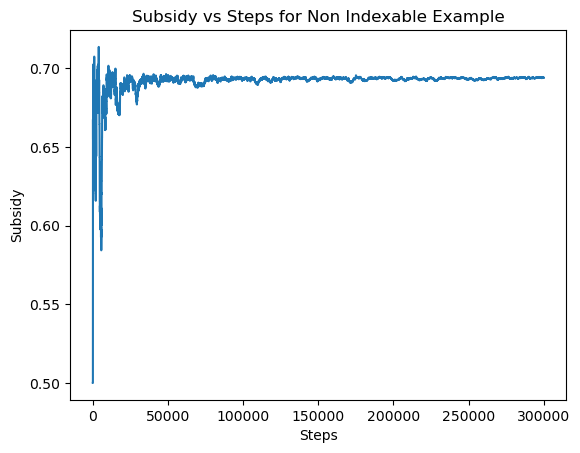

In [46]:
plt.plot(subsidies)
plt.xlabel('Steps')
plt.ylabel('Subsidy')
plt.title('Subsidy vs Steps for Non Indexable Example')

In [47]:
subsidies[-1]

0.6939564745260182

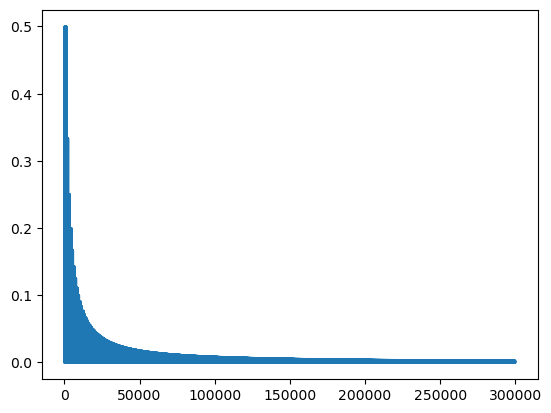

In [48]:
plt.plot(betas)

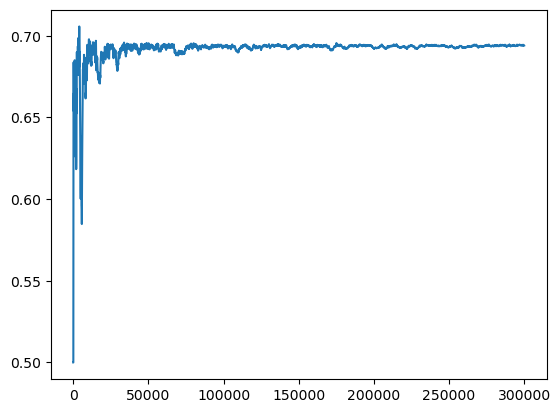

In [60]:
df_temp=pd.DataFrame(subsidies)
x=list(df_temp[0].rolling(100,min_periods=1).mean())
plt.plot(x)

In [61]:
x[-1]

0.6940222639997023

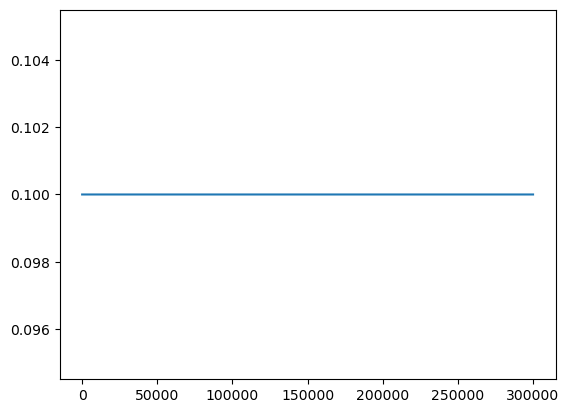

In [51]:
plt.plot(epsilons)

In [52]:
df=pd.DataFrame(rewards)


Text(0.5, 1.0, ' Moving Average of reward for Non Indexable Example ')

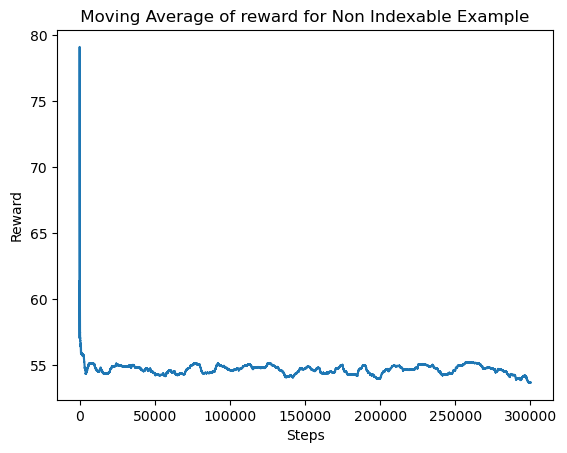

In [53]:
plt.plot(df[0].rolling(10000,min_periods=1).mean())
# plt.axhline(y = 14, color = 'r', linestyle = '-') 
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.title(' Moving Average of reward for Non Indexable Example ')


Text(0.5, 1.0, ' Moving Average of number of arms activated for Non Indexable Example ')

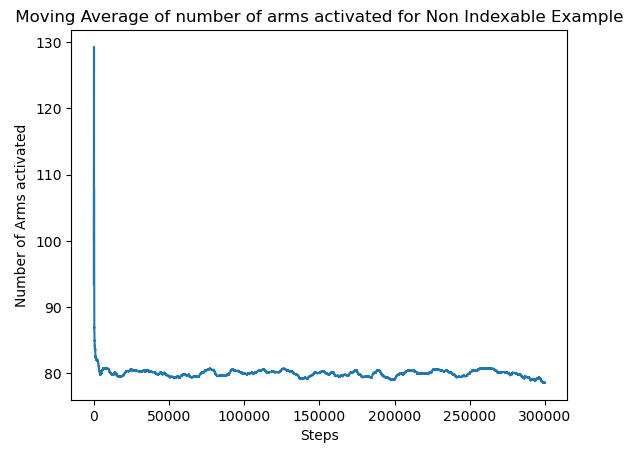

In [54]:
df['action_sums']=action_sums
plt.plot(df['action_sums'].rolling(10000,min_periods=1).mean())
plt.xlabel('Steps')
plt.ylabel('Number of Arms activated')
plt.title(' Moving Average of number of arms activated for Non Indexable Example ')


In [55]:
#using learnt indices
current_state=[0 for _ in range(N)]
reward_sums_alt_index=[]
alternative_indexes=[0 for _ in range(N)]
for i in range(1,10001):
  reward_sum_alt_index=0
  reward_sum_whittle_index=0
  for index in arm_indexes:
    alternative_indexes[index]=Q[current_state[index]][1]-Q[current_state[index]][0]
  indices_to_pull = sorted(range(len(alternative_indexes)), key = lambda j: alternative_indexes[j])[-M:]
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_alt_index+=reward
  reward_sums_alt_index.append(reward_sum_alt_index)


In [56]:
whittle_index_arms=[0 for _ in range(N)]
current_state=[0 for _ in range(N)]
reward_sums_whittle_index=[]
actual_whittle_indexes=[0.6941985627000107, 0.5085415824511699, 0.41540222368454144]

for i in range(1,10001):
  reward_sum_whittle_index=0
  for index in arm_indexes:
    whittle_index_arms[index]=actual_whittle_indexes[current_state[index]]
  #print(whittle_index_arms)
  indices_to_pull = sorted(range(len(whittle_index_arms)), key = lambda j: whittle_index_arms[j])[-M:]
  # print(indices_to_pull)
  for index in arm_indexes:
    if index in indices_to_pull:
      x=step(current_state[index],state_space,1,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
    else:
      x=step(current_state[index],state_space,0,P_0_matrix,P_1_matrix,reward_matrix)
      new_state=x[0]
      reward=x[1]
      current_state[index]=new_state
      reward_sum_whittle_index+=reward
  reward_sums_whittle_index.append(reward_sum_whittle_index)

Text(0.5, 1.0, ' Moving Average of reward for Non Whittle Indexable Example ')

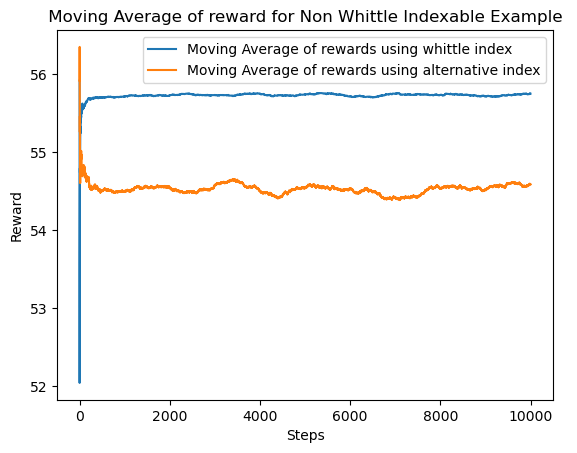

In [57]:
df=pd.DataFrame()
df['reward_whittle']=reward_sums_whittle_index
df['reward_alternate']=reward_sums_alt_index

plt.plot(df['reward_whittle'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using whittle index')
plt.plot(df['reward_alternate'][:50000].rolling(1000,min_periods=1).mean(),label='Moving Average of rewards using alternative index')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.legend()
plt.title(' Moving Average of reward for Non Whittle Indexable Example ')